In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## (a)

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])
# Transforms object for testset with NO augmentation
transform_no = transforms.Compose([])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='../data', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='../data', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## (b)
Extract class bird, which class label is 2

In [3]:
def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

In [4]:
# Separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = trainset.targets
y_test = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

# ================== Usage ================== #

# Let's choose cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
bird_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['bird'])],
        transform_no
    )
bird_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['bird'])],
        transform_no
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader   = DataLoader(bird_trainset, batch_size=len(bird_trainset), shuffle=False , **kwargs)
testsetLoader    = DataLoader(bird_testset , batch_size=len(bird_testset), shuffle=False, **kwargs)

In [5]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()


# get some random training images
dataiter = iter(trainsetLoader)
train_images, train_labels = dataiter.next()

test_images, test_labels = iter(testsetLoader).next()

images = torch.cat((train_images, test_images), 0)
labels = torch.cat((train_labels, test_labels), 0)

In [6]:
train_images[0]

tensor([[[164, 206,  84],
         [105, 140,  61],
         [118, 148, 101],
         ...,
         [109, 147,  73],
         [108, 147,  69],
         [ 91, 129,  57]],

        [[167, 213,  84],
         [116, 160,  49],
         [ 72, 109,  43],
         ...,
         [105, 142,  79],
         [105, 142,  72],
         [ 89, 127,  57]],

        [[140, 191,  65],
         [142, 193,  66],
         [119, 163,  79],
         ...,
         [104, 139,  84],
         [ 84, 120,  58],
         [ 78, 115,  49]],

        ...,

        [[139, 148,  81],
         [142, 155,  74],
         [135, 156,  72],
         ...,
         [ 89, 134,  28],
         [ 97, 148,  24],
         [126, 176,  49]],

        [[163, 157,  85],
         [153, 164,  82],
         [146, 164,  90],
         ...,
         [ 85, 130,  19],
         [ 98, 148,  27],
         [127, 178,  48]],

        [[183, 153, 102],
         [176, 182, 116],
         [154, 154, 100],
         ...,
         [ 94, 134,  29],
        

In [7]:
print(images.dtype)
print(images.shape)
print(labels.dtype)
print(labels.shape)

torch.uint8
torch.Size([6000, 32, 32, 3])
torch.int64
torch.Size([6000])


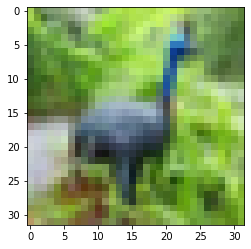

In [8]:
plt.imshow(torch.reshape(images[0], [32,32,3]))

In [9]:
torch.reshape(images[0], [32,32,3])

tensor([[[164, 206,  84],
         [105, 140,  61],
         [118, 148, 101],
         ...,
         [109, 147,  73],
         [108, 147,  69],
         [ 91, 129,  57]],

        [[167, 213,  84],
         [116, 160,  49],
         [ 72, 109,  43],
         ...,
         [105, 142,  79],
         [105, 142,  72],
         [ 89, 127,  57]],

        [[140, 191,  65],
         [142, 193,  66],
         [119, 163,  79],
         ...,
         [104, 139,  84],
         [ 84, 120,  58],
         [ 78, 115,  49]],

        ...,

        [[139, 148,  81],
         [142, 155,  74],
         [135, 156,  72],
         ...,
         [ 89, 134,  28],
         [ 97, 148,  24],
         [126, 176,  49]],

        [[163, 157,  85],
         [153, 164,  82],
         [146, 164,  90],
         ...,
         [ 85, 130,  19],
         [ 98, 148,  27],
         [127, 178,  48]],

        [[183, 153, 102],
         [176, 182, 116],
         [154, 154, 100],
         ...,
         [ 94, 134,  29],
        

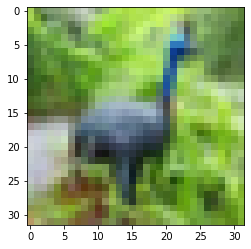

In [11]:
im = torch.reshape(images[0], [3, 32*32])
im = torch.transpose(im, 0, 1)
im = torch.reshape(images[0], [32,32,3])
plt.imshow(im)